In [2]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

In [3]:
import emcee
import sys
from astropy.table import Table
from astropy.io import ascii
import numpy as np
import matplotlib.pyplot as plt
import corner
default_color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
"""Generate parameter constraints with emcee and Gaussian Processes."""

import emcee
import stats_utils
import numpy as np
import argparse

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.stats import sem

In [5]:
class args:
    filename = 'noiseless.dat'
    data = 'PS'
    binmin = 300
    binmax = 5000
    mean_noise = 'K'
    cov_noise = 'K'
    redshift = ['10']
    smoothing_scale = '1.00'
    binscale = 'log'
    mcmc_N = 5000
    walkers = 64
    realizations = -1

MODEL_TO_REMOVE = 0 # MODEL 0 IS ALWAYS REMOVED

In [6]:
print(f'filename: {args.filename}')
print(f'data source: {args.data}')
print(f'redshifts: {args.redshift}')
print(f'bin min, binmax: {args.binmin}, {args.binmax}')
print(f'mean noise: {args.mean_noise}, cov noise: {args.cov_noise}')
print(f'smoothing scale: {args.smoothing_scale}, binscale: {args.binscale}')
print(f'number of realizations: {args.realizations}')

gp_list = []
def build_GP(params, ell, ps_mean):
    """
    Build a function that interpolates using GP.

    Returns
    -------
        function which takes in cosmological parameters, outputs interpolation

    """
    global gp_list
    gp_list = []
    datascale = []  # normalize each bin so mean is 1
    for test_ell_bin in range(len(ell)):
        X = params
        X = np.atleast_2d(X).T
        y = np.array(
            [np.mean(ps_temp[:args.realizations, :], axis=0)[test_ell_bin]
                for ps_temp in ps_mean])
        dy = np.array(
            [sem(ps_temp[:args.realizations, :], axis=0)[test_ell_bin]
                for ps_temp in ps_mean])
        datascale.append(np.mean(y))
        y /= datascale[-1]
        dy /= datascale[-1]

        kernel = C(5.0, (1e-4, 1e4)) * RBF([3, 0.3, 5], (1e-4, 1e4))
        gp = GaussianProcessRegressor(kernel=kernel,
                                      alpha=(dy)**2,
                                      n_restarts_optimizer=50,
                                      normalize_y=True)
        gp.fit(X, y)
        gp_list.append(gp)

    datascale = np.array(datascale)

    def get_PS_(x):
        y_pred_list = []
        sigma_list = []
        for gp in gp_list:
            y_pred, sigma = gp.predict(np.atleast_2d(x), return_std=True)
            y_pred_list.append(y_pred[0])
            sigma_list.append(sigma[0])

        return np.array(y_pred_list * datascale),\
            np.array(sigma_list * datascale)

    return get_PS_


# load up a parameter table
params = np.array([stats_utils.table['M_nu(eV)'],
                   stats_utils.table['Omega_m'],
                   stats_utils.table['10^9*A_s']])

# stitch together the realizations from different redshifts
ell = []
ps_real = []
for redshift in args.redshift:
    ell_, ps_real_ = stats_utils.get_real_list(args.data,
                                               noisy=args.mean_noise,
                                               redshift=redshift,
                                               bin_min=args.binmin,
                                               bin_max=args.binmax,
                                               smoothing=args.smoothing_scale,
                                               binscale=args.binscale)
    del ps_real_[MODEL_TO_REMOVE] # remove the model in question
    del ps_real_[0]  # DELETE FID A
    ell.append(ell_)
    ps_real.append(ps_real_)

ell = np.hstack(ell)
ps_real = np.dstack(ps_real)

#  DELETE FID A
params = np.delete(params, 0, axis=1)

# load the inverse covariance, and then train the Gaussian Process
invcov = stats_utils.get_invcov(args.data,
                                noisy=args.cov_noise,
                                redshifts=args.redshift,
                                bin_min=args.binmin,
                                bin_max=args.binmax,
                                smoothing=args.smoothing_scale,
                                binscale=args.binscale)
fid = np.mean(ps_real[0], axis=0)  # FID1 is now INDEX 0
get_PS = build_GP(params, ell, ps_real)


filename: noiseless.dat
data source: PS
redshifts: ['10']
bin min, binmax: 300, 5000
mean noise: K, cov noise: K
smoothing scale: 1.00, binscale: log
number of realizations: -1
nr 9999 nb 24 bin 0.99749949989998 sky 0.001225


/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.00016571, -0.00021137, -0.00043586, -0.00029805]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 16, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.00140269, -0.00169576, -0.00226704, -0.0019026 ]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 15, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.50522105e-04, -4.98082786e-04, -6.38979882e-04,  4.80483504e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 114, 'nit': 34, '

In [7]:

# set up some constants for prior evaluation
m_nu_min = 0.06  # minimum from oscillation experiments
m_nu_max = 2*np.max(stats_utils.table['M_nu(eV)'])
om_m_min = np.min(stats_utils.table['Omega_m'])
om_m_max = 2*np.max(stats_utils.table['Omega_m'])
A_s_min = np.min(stats_utils.table['10^9*A_s'])
A_s_max = 2*np.max(stats_utils.table['10^9*A_s'])


# define emcee function calls, prior, likelihood,
def lnprior(theta):
    """Ensure the sampler stays near computed simulations."""
    m_nu, om_m, A_s = theta
    if (m_nu_min < m_nu < m_nu_max and
            om_m_min < om_m < om_m_max and
            A_s_min < A_s < A_s_max):
        return 0.0
    return -np.inf


def lnlike(theta):
    """Compute the log likelihood based on multivariate Gaussian."""
    model, sig = get_PS(theta)
    dmu = fid - model
    return -0.5 * (np.dot(dmu, np.dot(invcov, dmu)))


def lnprob(theta):
    """Combine the likelihood and prior."""
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta)


# set up emcee
ndim, nwalkers = 3, args.walkers
p0 = [params.T[0] + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)


In [32]:
print(params.T[0])

array([0.1, 0.3, 2.1])

/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


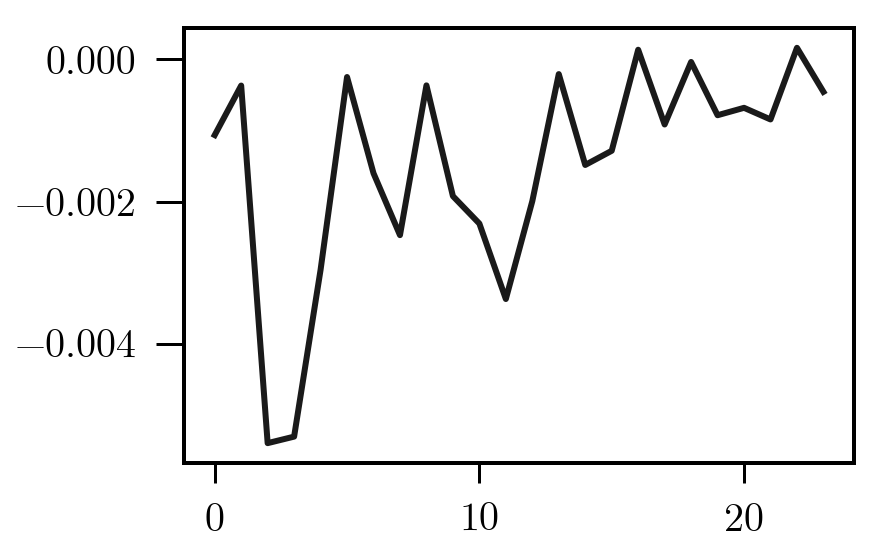

In [29]:
ys, sigmas = get_PS( np.array([0.22515023, 0.30164661, 2.22368606]) )
plt.plot( (ys - fid)/fid)

In [30]:
x0 = 0.1
y0 = 0.3
z0 = 2.1

/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


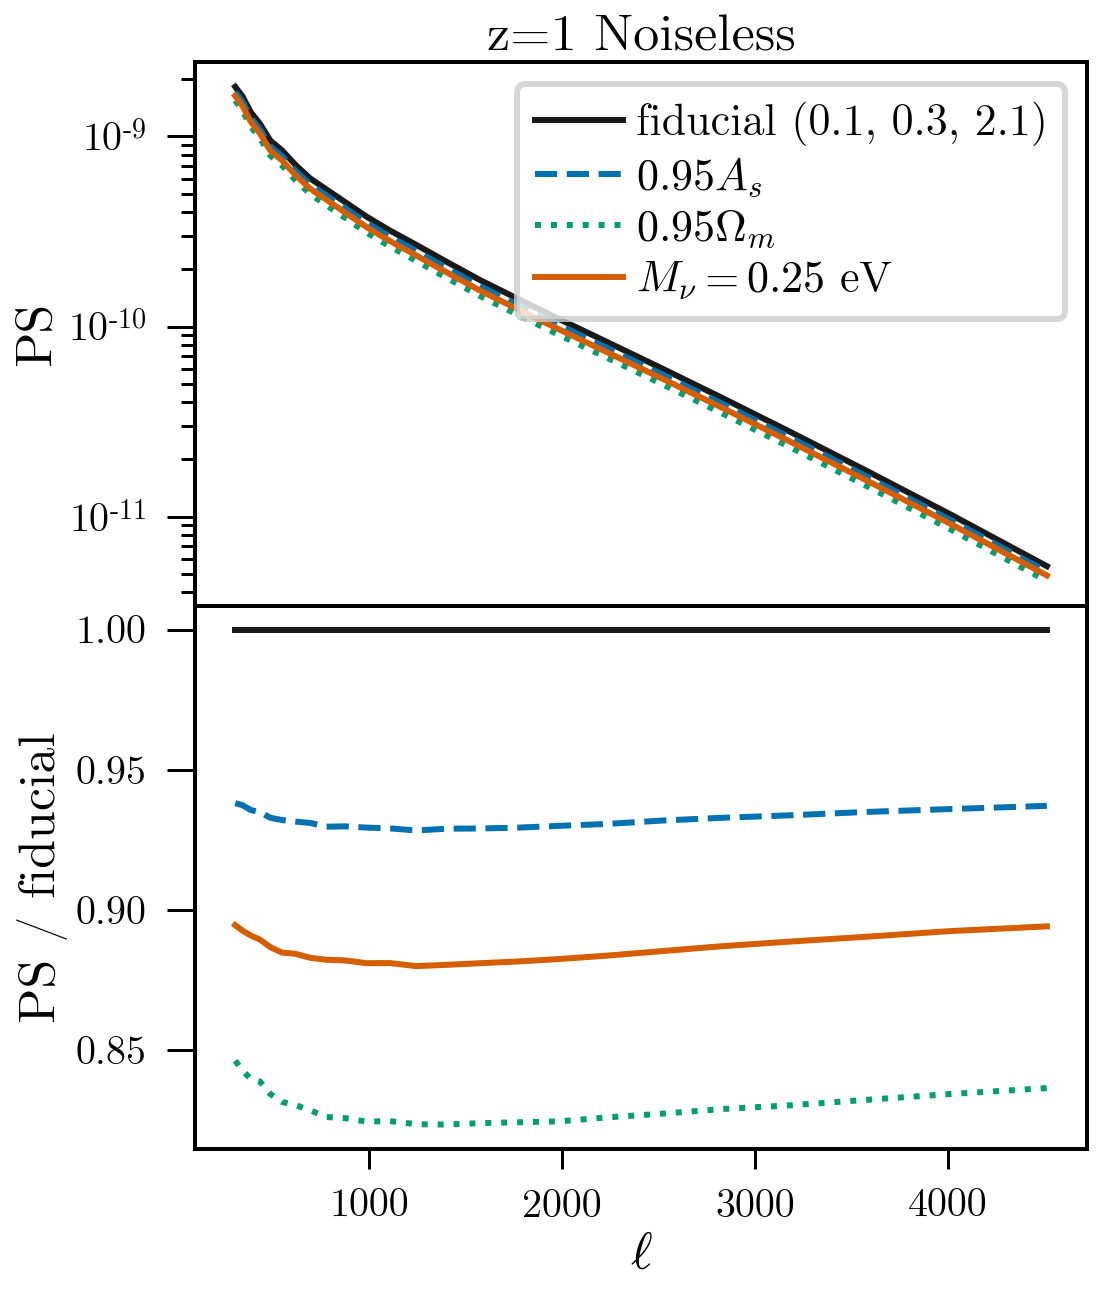

In [31]:
fig, ax = plt.subplots(2,1, figsize=(8,10), sharex=True)

fid_model, sigs = get_PS( [x0,y0,z0] )
ax[0].plot( ell, fid_model,
           '-', label='fiducial (0.1, 0.3, 2.1)')
ax[0].plot( ell, get_PS( [ x0   ,  y0   ,  z0 * 0.95 ] )[0],
           '-',label=r'$0.95 A_s$', ls='dashed' )
ax[0].plot( ell, get_PS( [ x0   ,  y0 * 0.95  ,  z0  ] )[0],
           '-',label=r'$0.95 \Omega_m$', ls='dotted' )
ax[0].plot( ell, get_PS( [ 0.25   ,  y0   , z0  ] )[0],
           '-',label=r'$M_{\nu} = 0.25$ eV', ls='solid' )
ax[0].legend()


plt.subplots_adjust(wspace=0, hspace=0)

ax[1].plot( ell, fid_model / fid_model ,
           '-', label='fiducial (0.1, 0.3, 2.1)')
ax[1].plot( ell, get_PS( [ x0   ,  y0   ,  z0 * 0.95 ] )[0] / fid_model,
           '-', label=r'$1.05 A_s$', ls='dashed' )
ax[1].plot( ell, get_PS( [ x0   ,  y0 * 0.95 ,  z0  ] )[0] / fid_model,
           '-', label=r'$1.05 \Omega_m$', ls='dotted' )
ax[1].plot( ell, get_PS( [ 0.25   ,  y0   , z0  ] )[0] / fid_model,
           '-', label=r'$M_{\nu} = 0.25$ eV', ls='solid' )
ax[0].legend(frameon=True)
# ax[1].set_ylim(0.8,1.2)

ax[0].set_ylabel('PS')
ax[1].set_ylabel('PS / fiducial')
ax[1].set_xlabel('$\ell$')
ax[0].set_yscale('log')
# ax[].set_yscale('log')
ax[0].set_title('z=1 Noiseless')

fig.savefig('figures/fig_effect_on_PS.pdf')

# Peaks

In [20]:

class args:
    filename = 'noiseless.dat'
    data = 'Peaks'
    binmin = -0.02
    binmax = 0.06
    mean_noise = 'K'
    cov_noise = 'K'
    redshift = ['10']
    smoothing_scale = '1.00'
    binscale = ''
    mcmc_N = 5000
    walkers = 64
    realizations = -1
    bin_center_row = 0

In [21]:
x0 = 0.1
y0 = 0.3
z0 = 2.1

In [22]:
print(f'filename: {args.filename}')
print(f'data source: {args.data}')
print(f'redshifts: {args.redshift}')
print(f'bin min, binmax: {args.binmin}, {args.binmax}')
print(f'mean noise: {args.mean_noise}, cov noise: {args.cov_noise}')
print(f'smoothing scale: {args.smoothing_scale}, binscale: {args.binscale}')
print(f'number of realizations: {args.realizations}')

gp_list = []
def build_GP(params, ell, ps_mean):
    """
    Build a function that interpolates using GP.

    Returns
    -------
        function which takes in cosmological parameters, outputs interpolation

    """
    global gp_list
    gp_list = []
    datascale = []  # normalize each bin so mean is 1
    for test_ell_bin in range(len(ell)):
        X = params
        X = np.atleast_2d(X).T
        y = np.array(
            [np.mean(ps_temp[:args.realizations, :], axis=0)[test_ell_bin]
                for ps_temp in ps_mean])
        dy = np.array(
            [sem(ps_temp[:args.realizations, :], axis=0)[test_ell_bin]
                for ps_temp in ps_mean])
        datascale.append(np.mean(y))
        y /= datascale[-1]
        dy /= datascale[-1]

        kernel = C(5.0, (1e-4, 1e4)) * RBF([3, 0.3, 5], (1e-4, 1e4))
        gp = GaussianProcessRegressor(kernel=kernel,
                                      alpha=(dy)**2,
                                      n_restarts_optimizer=50,
                                      normalize_y=True)
        gp.fit(X, y)
        gp_list.append(gp)

    datascale = np.array(datascale)

    def get_PS_(x):
        y_pred_list = []
        sigma_list = []
        for gp in gp_list:
            y_pred, sigma = gp.predict(np.atleast_2d(x), return_std=True)
            y_pred_list.append(y_pred[0])
            sigma_list.append(sigma[0])

        return np.array(y_pred_list * datascale),\
            np.array(sigma_list * datascale)

    return get_PS_


# load up a parameter table
params = np.array([stats_utils.table['M_nu(eV)'],
                   stats_utils.table['Omega_m'],
                   stats_utils.table['10^9*A_s']])

# stitch together the realizations from different redshifts
ell = []
ps_real = []
for redshift in args.redshift:
    ell_, ps_real_ = stats_utils.get_real_list(args.data,
                                               noisy=args.mean_noise,
                                               redshift=redshift,
                                               bin_min=args.binmin,
                                               bin_max=args.binmax,
                                               smoothing=args.smoothing_scale,
                                               binscale=args.binscale,
                                               bin_center_row=args.bin_center_row)
    del ps_real_[0]  # DELETE FID A
    ell.append(ell_)
    ps_real.append(ps_real_)

ell = np.hstack(ell)
ps_real = np.dstack(ps_real)

#  DELETE FID A
params = np.delete(params, 0, axis=1)

fid = np.mean(ps_real[0], axis=0)  # FID1 is now INDEX 0
get_Peaks = build_GP(params, ell, ps_real)


filename: noiseless.dat
data source: Peaks
redshifts: ['10']
bin min, binmax: -0.02, 0.06
mean noise: K, cov noise: K
smoothing scale: 1.00, binscale: 
number of realizations: -1


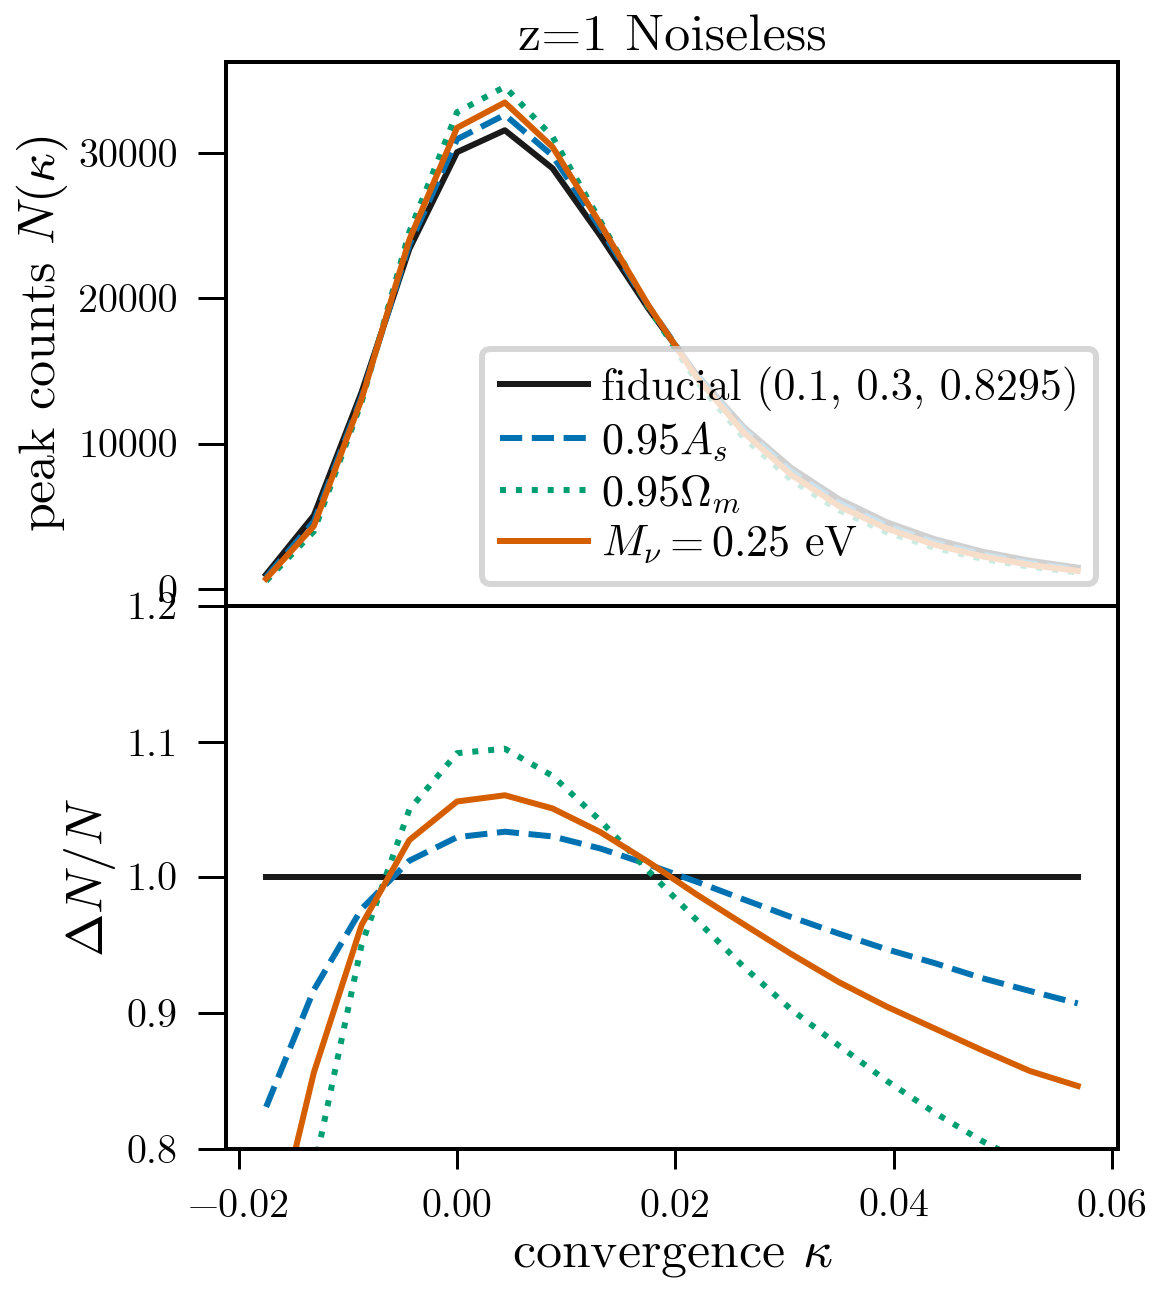

In [23]:
fig, ax = plt.subplots(2,1, figsize=(8,10), sharex=True)

fid_model = get_Peaks( [x0,y0,z0] )[0]
ax[0].plot( ell, fid_model ,
           '-', label='fiducial (0.1, 0.3, 0.8295)')
ax[0].plot( ell, get_Peaks( [ x0   ,  y0   ,  z0 * 0.95 ] )[0],
           '-', label=r'$0.95 A_s$', ls='dashed' )
ax[0].plot( ell, get_Peaks( [ x0   ,  y0 * 0.95  ,  z0  ] )[0],
           '-', label=r'$0.95 \Omega_m$', ls='dotted' )
ax[0].plot( ell, get_Peaks( [ 0.25   ,  y0   , z0  ] )[0],
           '-', label=r'$M_{\nu} = 0.25$ eV', ls='solid' )
ax[0].legend(loc=4, frameon=True)
# plt.legend()

plt.subplots_adjust(wspace=0, hspace=0)

ax[1].plot( ell, (fid_model / fid_model) ,
           '-', label='fiducial (0.1, 0.3, 0.8295)')
ax[1].plot( ell, get_Peaks( [ x0   ,  y0   ,  z0 * 0.95 ] )[0]  / fid_model,
           '-', label=r'$0.95 A_s$', ls='dashed' )
ax[1].plot( ell, get_Peaks( [ x0   ,  y0 * 0.95   , z0 ] )[0] / fid_model,
           '-', label=r'$0.95 \Omega_m$', ls='dotted' )
ax[1].plot( ell, get_Peaks( [ 0.25   ,  y0   , z0  ] )[0] / fid_model,
           '-', label=r'$M_{\nu} = 0.25$ eV', ls='solid' )
# ax[0].legend()
ax[1].set_ylim(0.8,1.2)

ax[0].set_ylabel('peak counts $N(\kappa)$')
ax[1].set_ylabel('$\Delta N / N$')
ax[1].set_xlabel('convergence $\kappa$')
ax[0].set_title('z=1 Noiseless')


fig.savefig('figures/fig_effect_on_PC_As.pdf')

# Peaks with SN

In [24]:

class args:
    filename = 'noiseless.dat'
    data = 'Peaks'
    binmin = -np.inf
    binmax = np.inf
    mean_noise = 'K'
    cov_noise = 'K'
    redshift = ['10']
    smoothing_scale = '1.00'
    binscale = ''
    mcmc_N = 5000
    walkers = 64
    realizations = -1
    bin_center_row = 1
    
x0 = 0.1
y0 = 0.3
z0 = 2.1

In [26]:
print(f'filename: {args.filename}')
print(f'data source: {args.data}')
print(f'redshifts: {args.redshift}')
print(f'bin min, binmax: {args.binmin}, {args.binmax}')
print(f'mean noise: {args.mean_noise}, cov noise: {args.cov_noise}')
print(f'smoothing scale: {args.smoothing_scale}, binscale: {args.binscale}')
print(f'number of realizations: {args.realizations}')

gp_list = []
def build_GP(params, ell, ps_mean):
    """
    Build a function that interpolates using GP.

    Returns
    -------
        function which takes in cosmological parameters, outputs interpolation

    """
    global gp_list
    gp_list = []
    datascale = []  # normalize each bin so mean is 1
    for test_ell_bin in range(len(ell)):
        X = params
        X = np.atleast_2d(X).T
        y = np.array(
            [np.mean(ps_temp[:args.realizations, :], axis=0)[test_ell_bin]
                for ps_temp in ps_mean])
        dy = np.array(
            [sem(ps_temp[:args.realizations, :], axis=0)[test_ell_bin]
                for ps_temp in ps_mean])
        datascale.append(np.mean(y))
        y /= datascale[-1]
        dy /= datascale[-1]

        kernel = C(5.0, (1e-4, 1e4)) * RBF([3, 0.3, 5], (1e-4, 1e4))
        gp = GaussianProcessRegressor(kernel=kernel,
                                      alpha=(dy)**2,
                                      n_restarts_optimizer=50,
                                      normalize_y=True)
        gp.fit(X, y)
        gp_list.append(gp)

    datascale = np.array(datascale)

    def get_PS_(x):
        y_pred_list = []
        sigma_list = []
        for gp in gp_list:
            y_pred, sigma = gp.predict(np.atleast_2d(x), return_std=True)
            y_pred_list.append(y_pred[0])
            sigma_list.append(sigma[0])

        return np.array(y_pred_list * datascale),\
            np.array(sigma_list * datascale)

    return get_PS_


# load up a parameter table
params = np.array([stats_utils.table['M_nu(eV)'],
                   stats_utils.table['Omega_m'],
                   stats_utils.table['10^9*A_s']])

# stitch together the realizations from different redshifts
ell = []
ps_real = []
for redshift in args.redshift:
    ell_, ps_real_ = stats_utils.get_real_list(args.data,
                                               noisy=args.mean_noise,
                                               redshift=redshift,
                                               bin_min=args.binmin,
                                               bin_max=args.binmax,
                                               smoothing=args.smoothing_scale,
                                               binscale=args.binscale,
                                               bin_center_row=args.bin_center_row)
    del ps_real_[0]  # DELETE FID A
    ell.append(ell_)
    ps_real.append(ps_real_)

ell = np.hstack(ell)
ps_real = np.dstack(ps_real)

#  DELETE FID A
params = np.delete(params, 0, axis=1)

fid = np.mean(ps_real[0], axis=0)  # FID1 is now INDEX 0
# get_Peaks = build_GP(params, ell, ps_real)


filename: noiseless.dat
data source: Peaks
redshifts: ['10']
bin min, binmax: -inf, inf
mean noise: K, cov noise: K
smoothing scale: 1.00, binscale: 
number of realizations: -1


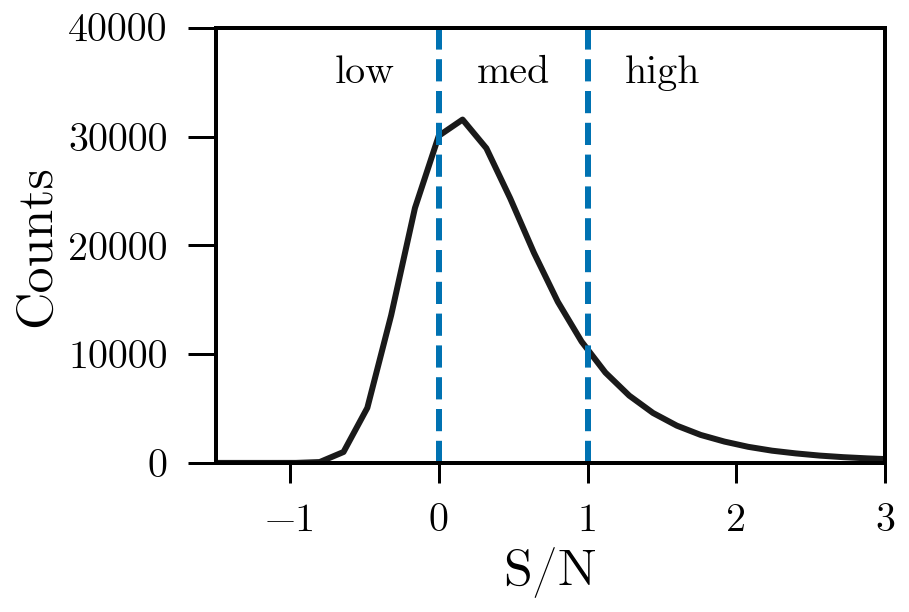

In [70]:
plt.plot( ell, fid )
plt.xlabel('S/N')
plt.ylabel('Counts')
plt.axvline(0, color=default_color_list[1], ls='--')
plt.axvline(1, color=default_color_list[1], ls='--')
plt.ylim(0,40000)
plt.xlim(-1.5,3)

plt.text(-0.5, 35000, 'low', fontsize=20, horizontalalignment='center')
plt.text(0.5, 35000, 'med', fontsize=20, horizontalalignment='center')
plt.text(1.5, 35000, 'high', fontsize=20, horizontalalignment='center')
plt.savefig('figures/different_SN_regions.pdf')

seems like a good range is -0.8 to infinity.

In [72]:
ell[7]

-0.7999999999999999